In [86]:
from datasets import load_dataset
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import Dataset, DataLoader

USE_IMAGENET_DATASET = True


class HFDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()

        self.dataset = dataset

    def __getitem__(self, index):
        data = self.dataset[index]
        return data["pixel_values"], data["label"]

    def __len__(self):
        return len(self.dataset)


def transforms(examples):
    examples["pixel_values"] = [transforms_list(image.convert("RGB")) for image in examples["image"]]
    return examples


transforms_list = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
        Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

if USE_IMAGENET_DATASET:
    dataset = {}
    for split in ["train", "validation", "test"]:
        dataset[split] = load_dataset("ILSVRC/imagenet-1k", trust_remote_code=True, split=split)

    dataset["train"].set_transform(transforms)
    dataset["validation"].set_transform(transforms)
    dataset["test"].set_transform(transforms)

    train_dataset = HFDataset(dataset["train"])
    validation_dataset = HFDataset(dataset["validation"])

In [ ]:
import torch
from torch import nn
from types import MethodType
from copy import deepcopy
from ramp_gae.utils import normalize_abs_sum_to_one, normalize_relevance, NormalizationType
import timm
from timm.models.resnet import BasicBlock, Bottleneck
import sys
from pydantic import BaseModel, ConfigDict
from abc import abstractmethod, ABC
from typing import Callable, Type, Optional, Dict


def print_positive_negative(relevance: torch.tensor) -> None:
    print("pos", relevance[0].relu().sum(), "neg", (-relevance).relu().sum())


model = timm.create_model("vgg16", pretrained=True)
# model = timm.create_model("resnet50", pretrained=True)
model.eval()


class LRPModuleRule(ABC):
    @abstractmethod
    def modified_forward_method(self) -> Optional[Callable]:
        raise NotImplementedError()

    @abstractmethod
    def modified_explain_method(self) -> Callable:
        raise NotImplementedError()

    def apply(self, module: nn.Module) -> None:
        modified_forward_method = self.modified_forward_method()
        if modified_forward_method is not None:
            module.forward = MethodType(modified_forward_method, module)
        module.explain = MethodType(self.modified_explain_method(), module)


class AbsLRPModuleRule(LRPModuleRule):
    def __init__(self, divide_relevance=True):
        self.divide_relevance = divide_relevance

    def modified_forward_method(self) -> Optional[Callable]:
        return None

    def modified_explain_method(self) -> Callable:
        if self.divide_relevance:
            return abslrp_rule
        return divide_abslrp_rule

    def apply(self, module: nn.Module) -> None:
        module.register_forward_hook(abslrp_forward_hook)
        super().apply(module=module)


class SequentialAbsLRPModuleRule(LRPModuleRule):
    def modified_forward_method(self) -> Optional[Callable]:
        return None

    def modified_explain_method(self) -> Callable:
        return sequential_abslrp_rule


class BasicBlockLRPModuleRule(LRPModuleRule):
    def modified_forward_method(self) -> Optional[Callable]:
        return modified_basic_block_forward

    def modified_explain_method(self) -> Callable:
        return basic_block_explain

    def apply(self, module: nn.Module) -> None:
        module.add_module("residual_addition", ResidualAddition())
        super().apply(module=module)


class BottleneckLRPModuleRule(LRPModuleRule):
    def modified_forward_method(self) -> Optional[Callable]:
        return modified_bottleneck_forward

    def modified_explain_method(self) -> Callable:
        return bottleneck_explain

    def apply(self, module: nn.Module) -> None:
        module.add_module("residual_addition", ResidualAddition())
        super().apply(module=module)


class LRPRule(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)

    module_to_rule_dict: Dict[Type[nn.Module], LRPModuleRule] = {}
    default_rule: LRPModuleRule
    default_composite_rule: LRPModuleRule

    def apply(self, module: nn.Module) -> None:
        # apply special rule if exists
        rule_applied = False
        for module_class, rule in self.module_to_rule_dict.items():
            if isinstance(module, module_class):
                rule.apply(module=module)
                rule_applied = True
                break
        # otherwise, apply default rule
        if not rule_applied:
            if not list(module.children()):
                self.default_rule.apply(module=module)
            else:
                self.default_composite_rule.apply(module=module)
        # apply this rule to all children of the module
        for child_module in module.children():
            self.apply(child_module)


class AbsLRPRule(LRPRule):
    default_rule: LRPModuleRule = AbsLRPModuleRule()
    default_composite_rule: LRPModuleRule = SequentialAbsLRPModuleRule()


class VGGAbsLRPRule(AbsLRPRule):
    module_to_rule_dict: Dict[Type[nn.Module], LRPModuleRule] = {nn.MaxPool2d: AbsLRPModuleRule(divide_relevance=False)}


class ResNetAbsLRPRule(AbsLRPRule):
    module_to_rule_dict: Dict[Type[nn.Module], LRPModuleRule] = {
        BasicBlock: BasicBlockLRPModuleRule(),
        Bottleneck: BottleneckLRPModuleRule(),
    }


class ResidualAddition(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x1: torch.tensor, x2: torch.tensor) -> torch.tensor:
        return x1 + x2


def modified_basic_block_forward(self, x: torch.tensor) -> torch.tensor:
    shortcut = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.drop_block(x)
    x = self.act1(x)
    x = self.aa(x)

    x = self.conv2(x)
    x = self.bn2(x)

    if self.se is not None:
        x = self.se(x)

    if self.drop_path is not None:
        x = self.drop_path(x)

    if self.downsample is not None:
        shortcut = self.downsample(shortcut)
    x = self.residual_addition(x, shortcut)
    x = self.act2(x)

    return x


def modified_bottleneck_forward(self, x: torch.tensor) -> torch.tensor:
    shortcut = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.act1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.drop_block(x)
    x = self.act2(x)
    x = self.aa(x)

    x = self.conv3(x)
    x = self.bn3(x)

    if self.se is not None:
        x = self.se(x)

    if self.drop_path is not None:
        x = self.drop_path(x)

    if self.downsample is not None:
        shortcut = self.downsample(shortcut)
    x = self.residual_addition(x, shortcut)
    x = self.act3(x)

    return x


def basic_block_explain(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    output_relevance = self.act2.explain(output_relevance, retain_graph)
    output_relevance, shortcut_relevance = self.residual_addition.explain(output_relevance, retain_graph=True)
    if self.downsample is not None:
        shortcut_relevance = self.downsample.explain(shortcut_relevance, retain_graph)
    if self.drop_path is not None:
        output_relevance = self.drop_path.explain(output_relevance, retain_graph)
    if self.se is not None:
        output_relevance = self.se.explain(output_relevance, retain_graph)
    output_relevance = self.bn2.explain(output_relevance, retain_graph)
    output_relevance = self.conv2.explain(output_relevance, retain_graph)
    output_relevance = self.aa.explain(output_relevance, retain_graph)
    output_relevance = self.act1.explain(output_relevance, retain_graph)
    output_relevance = self.drop_block.explain(output_relevance, retain_graph)
    output_relevance = self.bn1.explain(output_relevance, retain_graph)
    output_relevance = self.conv1.explain(output_relevance, retain_graph)

    output_relevance = output_relevance + shortcut_relevance

    return output_relevance


def bottleneck_explain(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    output_relevance = self.act3.explain(output_relevance, retain_graph)
    output_relevance, shortcut_relevance = self.residual_addition.explain(output_relevance, retain_graph=True)
    if self.downsample is not None:
        shortcut_relevance = self.downsample.explain(shortcut_relevance, retain_graph)
    if self.drop_path is not None:
        output_relevance = self.drop_path.explain(output_relevance, retain_graph)
    if self.se is not None:
        output_relevance = self.se.explain(output_relevance, retain_graph)
    output_relevance = self.bn3.explain(output_relevance, retain_graph)
    output_relevance = self.conv3.explain(output_relevance, retain_graph)
    output_relevance = self.aa.explain(output_relevance, retain_graph)
    output_relevance = self.act2.explain(output_relevance, retain_graph)
    output_relevance = self.drop_block.explain(output_relevance, retain_graph)
    output_relevance = self.bn2.explain(output_relevance, retain_graph)
    output_relevance = self.conv2.explain(output_relevance, retain_graph)
    output_relevance = self.act1.explain(output_relevance, retain_graph)
    output_relevance = self.bn1.explain(output_relevance, retain_graph)
    output_relevance = self.conv1.explain(output_relevance, retain_graph)

    output_relevance = output_relevance + shortcut_relevance

    return output_relevance


def identity_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    return output_relevance


def abslrp_rule(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    input = self.saved_tensors["input"]
    output = self.saved_tensors["output"]
    if "abs_output" in self.saved_tensors:
        output = output + self.saved_tensors["abs_output"]
    output_relevance = output_relevance / (self.saved_tensors["output"].abs() + 1e-9)
    # apply abslrp rule to each input
    grads = torch.autograd.grad(output, input, output_relevance, retain_graph=retain_graph)
    relevances = [arg * grad for arg, grad in zip(input, grads)]
    # calculate relevance sums for normalization
    relevance_sums = [relevance.flatten(1).abs().sum(-1) for relevance in relevances]
    max_relevance_sums = torch.stack(relevance_sums, 1).max(-1)[0]
    relevance_sums = [(relevance_sum / (max_relevance_sums + 1e-9))[:, None] for relevance_sum in relevance_sums]
    print(relevance_sums)
    # normalize relevances
    relevances = [
        normalize_relevance(
            relevance=relevance, normalization_type=NormalizationType.SUM_TO_ONE, output_factor=relevance_sum
        )
        for relevance, relevance_sum in zip(relevances, relevance_sums)
    ]
    # print(self.__class__.__name__, end=' ')
    # print_positive_negative(relevance=relevance)
    # delete saved tensors if not needed
    if not retain_graph:
        self.saved_tensors = {}
    if len(relevances) == 1:
        return relevances[0]
    return relevances


def divide_abslrp_rule(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    input = self.saved_tensors["input"]
    output = self.saved_tensors["output"]
    if "abs_output" in self.saved_tensors:
        output = output + self.saved_tensors["abs_output"]
    output_relevance = output_relevance
    # apply abslrp rule to each input
    grads = torch.autograd.grad(output, input, output_relevance, retain_graph=retain_graph)
    relevances = [arg * grad for arg, grad in zip(input, grads)]
    # calculate relevance sums for normalization
    relevance_sums = [relevance.flatten(1).abs().sum(-1) for relevance in relevances]
    max_relevance_sums = torch.stack(relevance_sums, 1).max(-1)[0]
    relevance_sums = [(relevance_sum / (max_relevance_sums + 1e-9))[:, None] for relevance_sum in relevance_sums]
    print(relevance_sums)
    # normalize relevances
    relevances = [
        normalize_relevance(
            relevance=relevance, normalization_type=NormalizationType.SUM_TO_ONE, output_factor=relevance_sum
        )
        for relevance, relevance_sum in zip(relevances, relevance_sums)
    ]
    # print(self.__class__.__name__, end=' ')
    # print_positive_negative(relevance=relevance)
    # delete saved tensors if not needed
    if not retain_graph:
        self.saved_tensors = {}
    if len(relevances) == 1:
        return relevances[0]
    return relevances


def sequential_abslrp_rule(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    for child in list(self.children())[::-1]:
        # print("composite", child, output_relevance.shape)
        output_relevance = child.explain(output_relevance=output_relevance, retain_graph=retain_graph)
    return output_relevance


def abslrp_forward_hook(module: nn.Module, args: tuple, output: torch.tensor) -> None:
    module.saved_tensors = {}
    # create a temporary temp module
    abs_module = deepcopy(module)
    # remove this hook from copied model
    if getattr(abs_module, "_forward_hooks", None):
        for i, hook in abs_module._forward_hooks.items():
            if hook.__name__ == "abslrp_forward_hook":
                break
        del abs_module._forward_hooks[i]
    # if module has learnable parameters, infer over absolute parameters
    if getattr(module, "weight", None) is not None:
        abs_module.weight.data = abs_module.weight.data.abs()
        if getattr(module, "bias", None) is not None:
            abs_module.bias.data = abs_module.bias.data.abs()
    abs_output = abs_module(*[arg.abs() for arg in args])
    # save the outputs and inputs
    # print(module.__class__.__name__, args[0].shape, output.shape)
    module.saved_tensors["abs_output"] = abs_output
    module.saved_tensors["output"] = output
    module.saved_tensors["input"] = args


if isinstance(model, timm.models.vgg.VGG):
    VGGAbsLRPRule().apply(model)
else:
    ResNetAbsLRPRule().apply(model)
# apply_rule(model, VGGAbsLRPRule() if isinstance(model, timm.models.vgg.VGG) else ResNetAbsLRPRule())

In [88]:
"""model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 2, bias=False))

model[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])
model[1].weight.data = torch.tensor([[1.0, 0], [0, 1]])

x = torch.tensor([[1.0, 1]])
x.requires_grad = True

apply_rule(model, AbsLRPRule())

model(x), model.explain(torch.tensor([[1.0, -1]]))"""

'model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 2, bias=False))\n\nmodel[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])\nmodel[1].weight.data = torch.tensor([[1.0, 0], [0, 1]])\n\nx = torch.tensor([[1.0, 1]])\nx.requires_grad = True\n\napply_rule(model, AbsLRPRule())\n\nmodel(x), model.explain(torch.tensor([[1.0, -1]]))'

In [89]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [90]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image

if USE_IMAGENET_DATASET:
    validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)
    for x, y in validation_loader:
        break
else:
    image = Image.open("dog_cat.jpg").convert("RGB")
    x = transforms_list(image)[None]

x.requires_grad = True
output = model(x)
s_output = output.softmax(-1)

# sglrp
# output_relevance = torch.autograd.grad(s_output.sum(), output)[0]
# clrp
output_relevance = torch.ones_like(output)
positive_mask = F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])

positive_relevance = model.explain(output_relevance=(output_relevance * positive_mask).abs(), retain_graph=True)
negative_relevance = model.explain(output_relevance=(output_relevance * (1 - positive_mask)).abs())

relevance = positive_relevance - negative_relevance

print(relevance[0].sum())

[tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<UnsqueezeBackward0>)]
[tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<UnsqueezeBackward0>)]
[tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<UnsqueezeBackward0>)]
[tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<UnsqueezeBackward0>)]
[tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<UnsqueezeBackward0>)]
[tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<UnsqueezeBackward0>)]
[tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<Unsquee

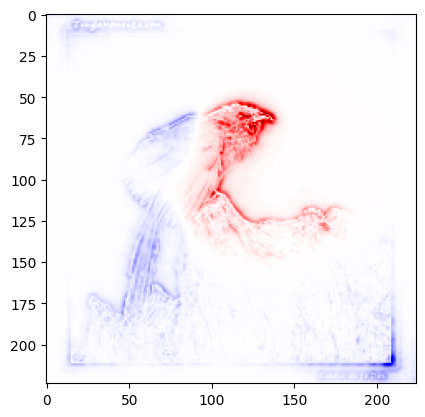

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
from ramp_gae.utils import normalize_relevance, NormalizationType

vis_example = 0
plt.imshow(normalize_relevance(relevance.sum(1), normalization_type=NormalizationType.MAX_TO_ONE)[vis_example].detach().cpu(), vmin=-1, vmax=1, cmap="seismic")
plt.show()

In [35]:
output[5].max(-1)[1]

tensor(658)

In [36]:
dataset["train"].features["label"].int2str(output.max(-1)[1])

['coucal',
 'Italian greyhound',
 'volcano',
 'Welsh springer spaniel',
 'chickadee',
 'mitten',
 'wallet, billfold, notecase, pocketbook',
 'sombrero']

In [ ]:
x.requires_grad = True
output = model(x)
output_relevance = F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])
positive_relevance = model.explain(output_relevance=output_relevance)

output = model(x)
output_relevance = 1 - F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])
negative_relevance = model.explain(output_relevance=output_relevance)

relevance = normalize_abs_sum_to_one(positive_relevance) - normalize_abs_sum_to_one(negative_relevance)

output tensor(1)
<class 'torch.nn.modules.linear.Linear'> tensor(1.) tensor(1) tensor(0) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.dropout.Dropout'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.flatten.Flatten'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.conv.Conv2d'> tensor(1.0000) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.0000)
<class 'torch.nn.modules.dropout.Dropout'> tensor(1.0000) tensor(1.0000) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.0000)
<class 'torch.nn.modules.conv.Conv2d'> tensor(1.0000) t

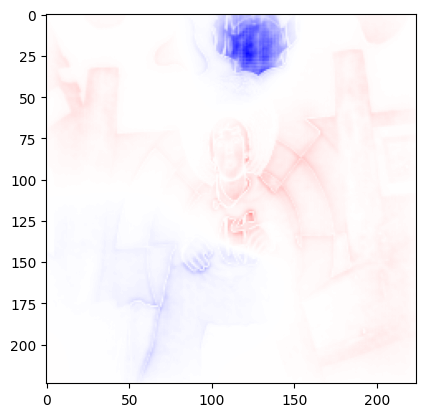

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from ramp_gae.utils import normalize_relevance, NormalizationType

vis_example = 7
plt.imshow(normalize_relevance(relevance.sum(1), normalization_type=NormalizationType.MAX_TO_ONE)[vis_example].detach().cpu(), vmin=-1, vmax=1, cmap="bwr")
plt.show()

# Test model

In [ ]:
model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 1, bias=False))

model[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])
model[1].weight.data = torch.tensor([[1.0, 1]])

x = torch.tensor([[1.0, 1]])
x.requires_grad = True

apply_rule(model, AbsLRPRule())

model(x), model.explain(torch.tensor([[1.0]]))

layer = nn.Linear(2, 2, bias=False)
layer.weight.data = torch.tensor([[2.0, -1], [-5, 6]])
abs_layer = deepcopy(layer)
abs_layer.weight.data = abs_layer.weight.data.abs()

h = layer(x)
ha = abs_layer(x)

torch.autograd.grad(h + ha, x, torch.tensor([[0.5, 0.5]]) / h.abs())[0] * x